In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
import numpy as np

In [2]:
orders = pd.read_csv("./Data/order.csv", header=0, index_col=0)
products = pd.read_csv("./Data/product.csv", header=0, index_col=0, 
    dtype={
        'category': 'str',
        'collection': 'str',
        'color': 'str',
        'metal': 'str',  # Specify types explicitly if needed
    }
)
final_df = orders.merge(products, on="product_id_with_size", how="left")

In [3]:
import feature_egnineering as FE
import utils as UT

In [4]:
UT.setup_logger()

[2024-12-30 23:17:38,572] [INFO] [utils]: Logger set up: ./logs.log


In [5]:
consumer_features = FE.generate_consumer_features(final_df, "2024-01-01")

[2024-12-30 23:17:38,589] [INFO] [feature_egnineering]: Computing features for consumers.
[2024-12-30 23:17:38,660] [INFO] [feature_egnineering]: Computing recency for consumers.
[2024-12-30 23:17:39,192] [INFO] [feature_egnineering]: Recency computation completed for 319074 consumers.
[2024-12-30 23:17:39,788] [INFO] [feature_egnineering]: Computing total baskets for consumers.
[2024-12-30 23:17:40,371] [INFO] [feature_egnineering]: Total baskets computed for 319074 consumers.
[2024-12-30 23:17:41,038] [INFO] [feature_egnineering]: Computing total spend money for consumers.
[2024-12-30 23:17:41,572] [INFO] [feature_egnineering]: Total spend money computed for 319074 consumers.
[2024-12-30 23:17:42,238] [INFO] [feature_egnineering]: Computing total refund money for consumers.
c:\Users\a.iliopoulos_xe\Desktop\pandoras_ML\assigment\feature_egnineering.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [6]:
num_cols = ["total_baskets", "total_spend_money", 
            "total_refund_money", "total_net_revenue", 
            "average_basket_spend", "total_items_purchased", 
            "total_distinct_items_purchased", "total_returned_items", 
            "favourite_day_of_week"]
dropna_cols = ["consumer_id","recency", "favourite_day_of_week", "favourite_metal", 
               "favourite_store_type", "prefer_theme"]
consumer_features[num_cols] = consumer_features[num_cols].fillna(value=0)
consumer_features = consumer_features.dropna(subset=dropna_cols)
consumer_features = consumer_features.reset_index(drop=True)
consumer_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315462 entries, 0 to 315461
Data columns (total 14 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   consumer_id                     315462 non-null  object 
 1   recency                         315462 non-null  float64
 2   total_baskets                   315462 non-null  float64
 3   total_spend_money               315462 non-null  float64
 4   total_refund_money              315462 non-null  float64
 5   total_net_revenue               315462 non-null  float64
 6   average_basket_spend            315462 non-null  float64
 7   total_items_purchased           315462 non-null  float64
 8   total_distinct_items_purchased  315462 non-null  float64
 9   total_returned_items            315462 non-null  float64
 10  favourite_day_of_week           315462 non-null  float64
 11  favourite_metal                 315462 non-null  object 
 12  favourite_store_

In [7]:
metal_df = final_df[["metal"]].drop_duplicates().sort_values(by="metal", ascending=True).reset_index(drop=True)
store_type_df = final_df[["store_type"]].drop_duplicates().sort_values(by="store_type", ascending=True).reset_index(drop=True)

encoder_metal = OneHotEncoder(sparse_output=False, drop=None)
encoder_store_type = OneHotEncoder(sparse_output=False, drop=None)

encoded_metal = encoder_metal.fit_transform(metal_df)
encoded_store_type = encoder_store_type.fit_transform(store_type_df)

encoded_metal_df = pd.DataFrame(encoded_metal, columns=encoder_metal.get_feature_names_out(["metal"]))
encoded_store_type_df = pd.DataFrame(encoded_store_type, columns=encoder_store_type.get_feature_names_out(["store_type"]))

metal_df = pd.concat([metal_df, encoded_metal_df], axis=1)
metal_df = metal_df.rename(columns={"metal": "favourite_metal"})
store_type_df = pd.concat([store_type_df, encoded_store_type_df], axis=1)
store_type_df = store_type_df.rename(columns={"store_type": "favourite_store_type"})

In [8]:
consumer_features = consumer_features.merge(metal_df, on='favourite_metal', how='left')
consumer_features = consumer_features.merge(store_type_df, on='favourite_store_type', how='left')
consumer_features = consumer_features.drop(columns=["favourite_metal", "favourite_store_type"])

In [9]:
consumer_features.to_parquet("./consumers_features.parquet.gzip", compression='gzip', index=False)

In [10]:
consumer_features = pd.read_parquet("./consumers_features.parquet.gzip")

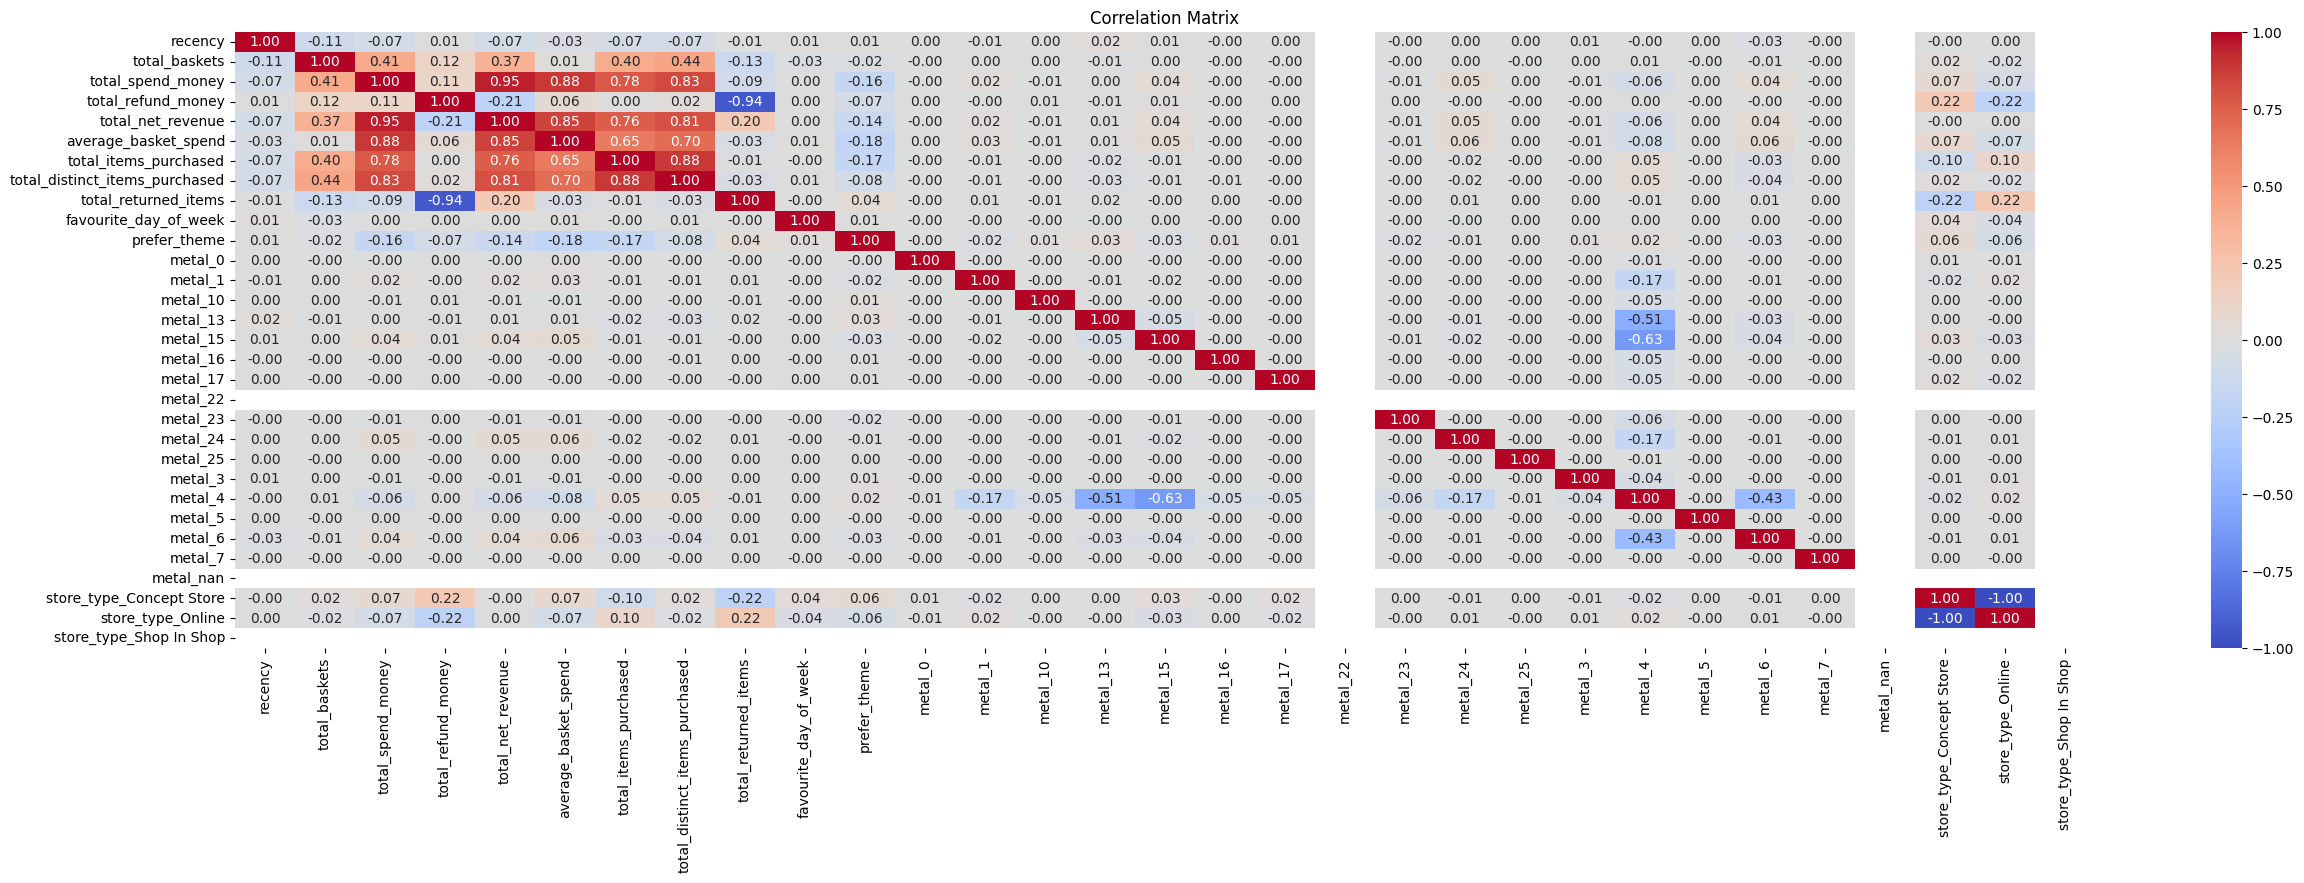

In [11]:
correlation_matrix = consumer_features.drop(columns=["consumer_id"]).corr()

# Plot the correlation heatmap
plt.figure(figsize=(30, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

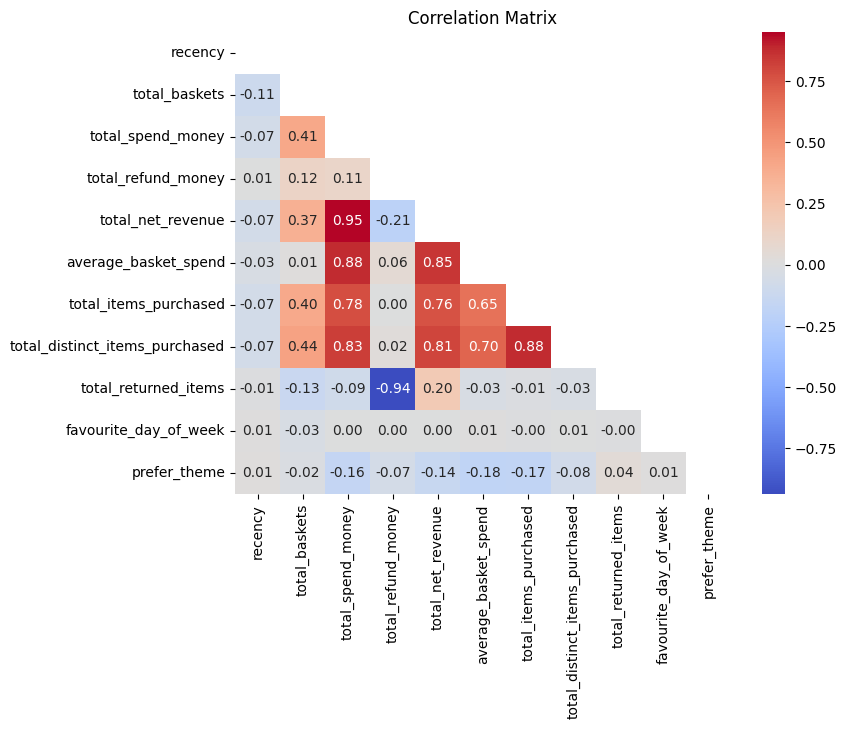

In [12]:
exclude_cols = [cl for cl in consumer_features.columns.to_list() if (("store_type_" in cl.lower()) or ("metal" in cl.lower()) or ("consumer_id" in cl.lower()))]
correlation_matrix = consumer_features.drop(columns=exclude_cols).corr()

# Plot the correlation heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap with the mask
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [13]:
consumer_features[consumer_features.drop(columns=exclude_cols).columns.to_list()]

,recency,total_baskets,total_spend_money,total_refund_money,total_net_revenue,average_basket_spend,total_items_purchased,total_distinct_items_purchased,total_returned_items,favourite_day_of_week,prefer_theme
0,30.0,1.0,973.91,0.0,973.91,973.91,2.0,2.0,0.0,5.0,0.0
1,10.0,1.0,973.12,0.0,973.12,973.12,2.0,2.0,0.0,4.0,0.0
2,25.0,1.0,399.45,0.0,399.45,399.45,2.0,2.0,0.0,3.0,1.0
3,266.0,1.0,546.25,0.0,546.25,546.25,1.0,1.0,0.0,0.0,0.0
4,327.0,1.0,242.06,0.0,242.06,242.06,1.0,1.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
315457,159.0,1.0,302.44,0.0,302.44,302.44,1.0,1.0,0.0,2.0,1.0
315458,86.0,1.0,350.48,0.0,350.48,350.48,1.0,1.0,0.0,5.0,1.0
315459,289.0,1.0,545.85,0.0,545.85,545.85,1.0,1.0,0.0,5.0,1.0
315460,233.0,1.0,645.61,0.0,645.61,645.61,2.0,2.0,0.0,5.0,0.0


In [14]:
exclude_cols = [cl for cl in consumer_features.columns.to_list() 
                if (
                    ("store_type_" in cl.lower()) or 
                    ("metal" in cl.lower()) or 
                    ("consumer_id" in cl.lower()) or
                    ("prefer_theme"  in cl.lower()) or
                    ("favourite_day_of_week"  in cl.lower())
                )]
scaler = StandardScaler()

consumer_features[consumer_features.drop(columns=exclude_cols).columns.to_list()] = scaler.fit_transform(consumer_features[consumer_features.drop(columns=exclude_cols).columns.to_list()])

In [17]:
exclude_cols = [cl for cl in consumer_features.columns.to_list() 
                if (
                    ("store_type_" in cl.lower()) or 
                    ("metal" in cl.lower()) or 
                    ("consumer_id" in cl.lower()) or
                    ("prefer_theme"  in cl.lower()) or
                    ("favourite_day_of_week"  in cl.lower())
                )]
# exclude_cols = ["consumer_id"]
consumer_features_pca = consumer_features.drop(columns=exclude_cols)

pca = PCA()
pca.fit(consumer_features_pca)

explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)


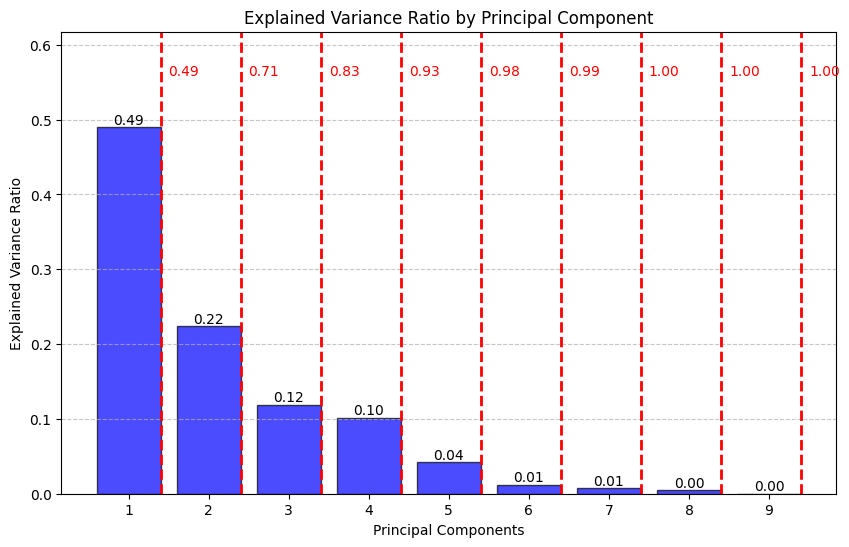

In [15]:
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, len(explained_var) + 1), explained_var, color='blue', alpha=0.7, edgecolor='black')

current_ylim = plt.ylim()
plt.ylim(top=current_ylim[1] * 1.2)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

for bar,cum_var_n in zip(bars, cum_var):
    point_x = bar.get_x() + bar.get_width()
    plt.axvline(x=point_x, color='red', linestyle='--', linewidth=2)
    plt.text(point_x+0.1, plt.ylim()[1] * 0.9, f'{cum_var_n:.2f}', ha='left', va='bottom', fontsize=10, color='red')

plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(range(1, len(explained_var) + 1))  # Set x-axis ticks to match component numbers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [16]:
exclude_cols = [cl for cl in consumer_features.columns.to_list() 
                if (
                    ("store_type_" in cl.lower()) or 
                    ("metal" in cl.lower()) or 
                    ("consumer_id" in cl.lower()) or
                    ("prefer_theme"  in cl.lower()) or
                    ("favourite_day_of_week"  in cl.lower())
                )]
# exclude_cols = ["consumer_id"]
consumer_features_pca = consumer_features.drop(columns=exclude_cols)

pca = PCA(n_components=5)
pca.fit(consumer_features_pca)

transformed_data = pca.transform(consumer_features_pca)
transformed_data = pd.DataFrame(transformed_data, columns=[f"Comp_{i+1}" for i in range(5)])

In [17]:
consumer_features_w_pca = pd.concat([consumer_features[exclude_cols], transformed_data], axis=1)

,recency,total_baskets,total_spend_money,total_refund_money,total_net_revenue,average_basket_spend,total_items_purchased,total_distinct_items_purchased,total_returned_items
Comp_1,-0.047448,0.213929,0.460756,0.005286,0.451852,0.404082,0.422686,0.439922,-0.003461
Comp_2,0.001251,-0.142765,-0.056724,-0.689529,0.157714,0.004617,-0.002711,-0.020947,0.689643
Comp_3,0.712707,-0.594114,0.071935,0.073051,0.048177,0.345648,-0.042477,-0.037071,-0.059951
Comp_4,0.699366,0.606453,-0.052206,-0.075287,-0.028067,-0.338473,0.090555,0.089265,0.056458
Comp_5,-0.025233,-0.322607,-0.328481,-0.025687,-0.315345,-0.262847,0.654371,0.434867,-0.029783


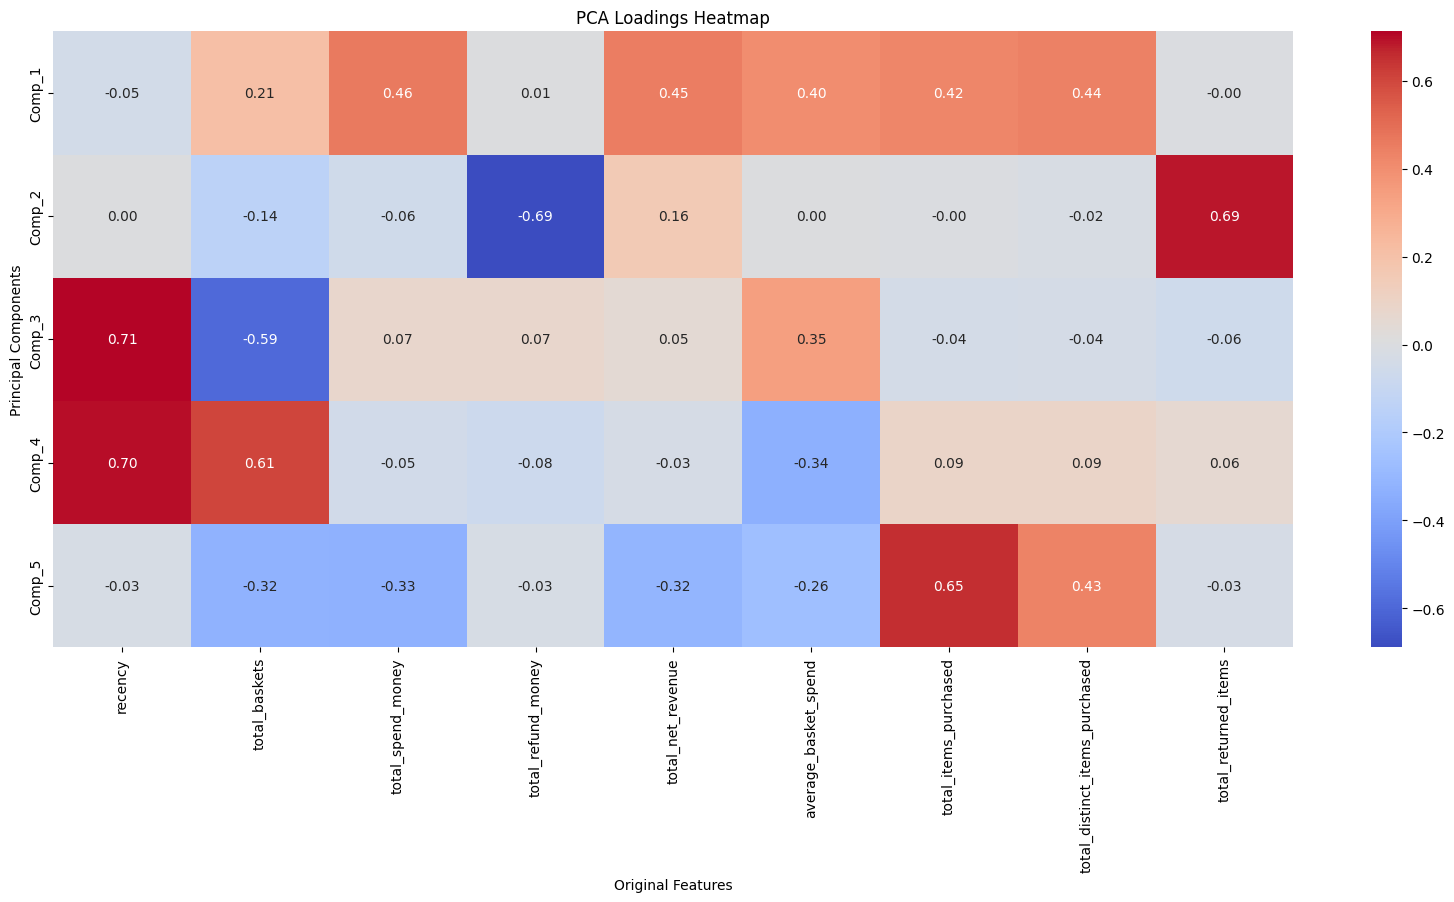

In [18]:
components_vs_features = pd.DataFrame(
    pca.components_,
    columns=consumer_features_pca.columns,
    index=[f"Comp_{i+1}" for i in range(pca.n_components_)]
)

display(components_vs_features)

plt.figure(figsize=(20, 8))
sns.heatmap(components_vs_features, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("PCA Loadings Heatmap")
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.show()
